In [78]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad  # интеграл
import time

In [79]:
def DFT_slow(x):
    """Дискретное преобразование Фурье"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

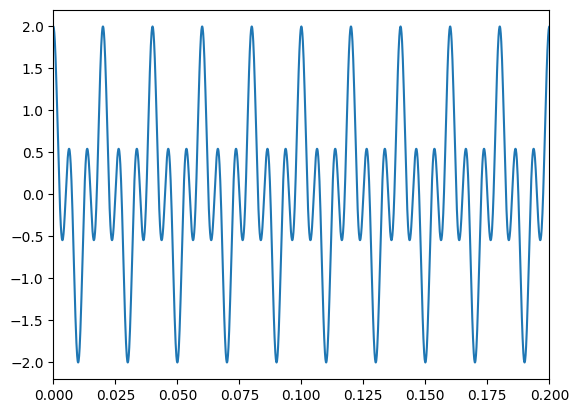

In [80]:
#Объявление констант
num_point = 10000
t0 = 0
t1 = 1
f_cos1 = 50
f_cos2 = 150
w1 = 2*np.pi*f_cos1
w2 = 2*np.pi*f_cos2

#Создание сигнала и дискретной шкалы времени
t_cos = np.linspace(t0, t1, num_point)
y = np.cos(w1*t_cos) + np.cos(w2*t_cos)
plt.plot(t_cos, y)
plt.xlim(0, 0.2)
plt.show()

In [81]:
#Подсчёт времени FFT
start_time = time.time()
y_fft = np.fft.fft(y)
end_time = time.time()
time_FFT = end_time - start_time

#Подсчёт времени DFT
start_time = time.time()
y_dft = DFT_slow(y)
end_time = time.time()
time_DFT = end_time - start_time
print("FFT:", time_FFT,
      "DFT:", time_DFT)

FFT: 0.000331878662109375 DFT: 3.494776725769043


/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


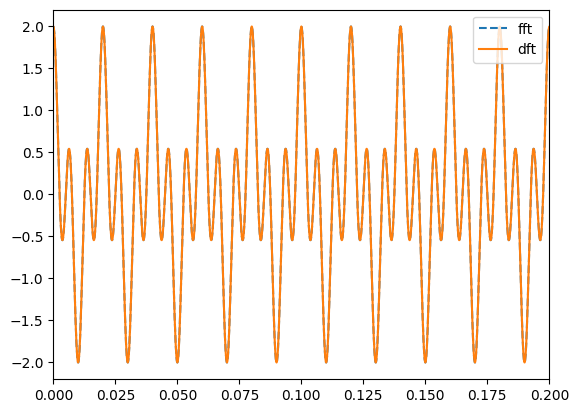

In [82]:
#Обратное преобразование и сравнение
y1 = np.fft.ifft(y_fft)
y2 = np.fft.ifft(y_dft)
plt.plot(t_cos, y1, linestyle='--', label="fft")
plt.plot(t_cos, y2, label="dft")
plt.xlim(0, 0.2)
plt.legend()
plt.show()

In [83]:
#функция добавляющая белый (гауссовский) шум
def add_noise(y):
    noise = np.random.normal(0, 1, y.shape)
    return y + noise

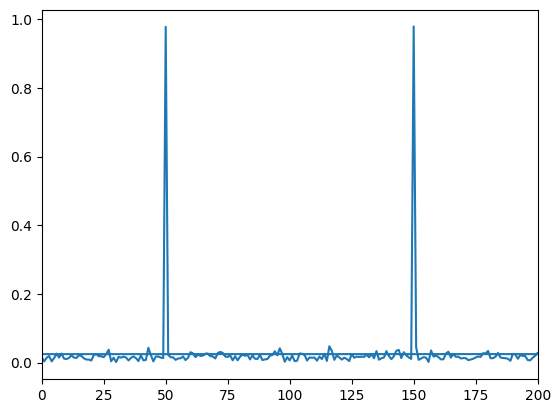

In [84]:
#подсчёт и вывод спектра x(t) = cos(w1t) + cos(w2t) с нормальным шумом по slow дискретному преобразованию фурье
y_dft_noise = DFT_slow(add_noise(y))
y3 = np.fft.ifft(y_dft_noise)
freq_cos = np.fft.fftfreq(len(t_cos), d=(t_cos[1]-t_cos[0]))
plt.plot(freq_cos, np.abs(y_dft_noise) / num_point * 2, label = 'F(x(t))')
plt.xlim(0, 200)
plt.show()

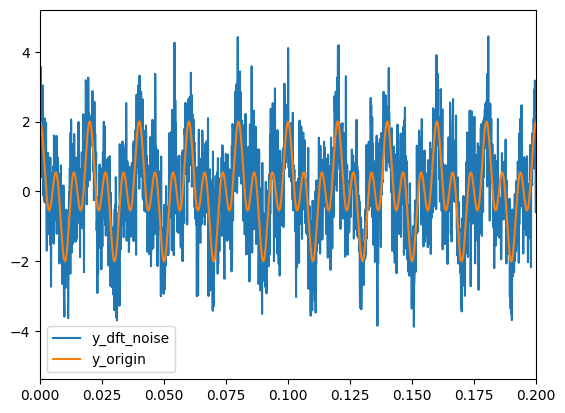

In [85]:
#сравнение функции y с функцией F^(-1)(F(y + noise))
plt.plot(t_cos, y3, label = 'y_dft_noise')
plt.plot(t_cos, y, linestyle='-', label = 'y_origin')
plt.xlim(0, 0.2)
plt.legend()
plt.show()

In [86]:
#функция - периодический прямоугольный сигнал
def square_signal(t, A, T):
    return A * signal.square(2 * np.pi * t / T)

In [87]:
#Объявление основных констант
t0 = 0
t1 = 4
T = 2
A = 2
num_point = 10000
f_square = 2*np.pi / T
t_square = np.linspace(t0, t1, num_point)
y_square = square_signal(t_square, A, T)

In [88]:
#Подсчёт спектра slow преобразованием фурье и преобразованием от numpy
y_dft = DFT_slow(y_square)
y_fft = np.fft.fft(y_square)
freq_cos = np.fft.fftfreq(len(t_cos), d=(t_cos[1]-t_cos[0]))

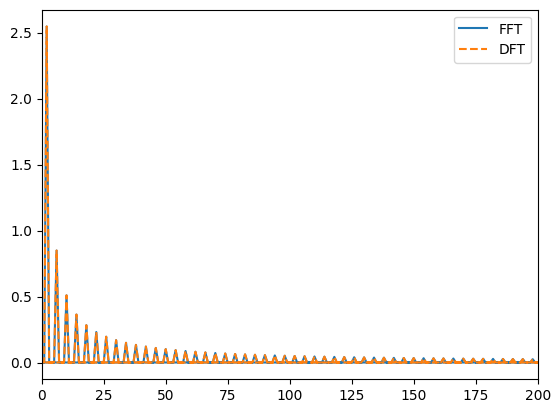

In [89]:
#Сравнение спектров
plt.plot(freq_cos, np.abs(y_fft) / num_point * 2, label = "FFT")
plt.plot(freq_cos, np.abs(y_dft) / num_point * 2, linestyle='dashed', label = "DFT")
plt.legend()
plt.xlim(0, 200)
plt.show()

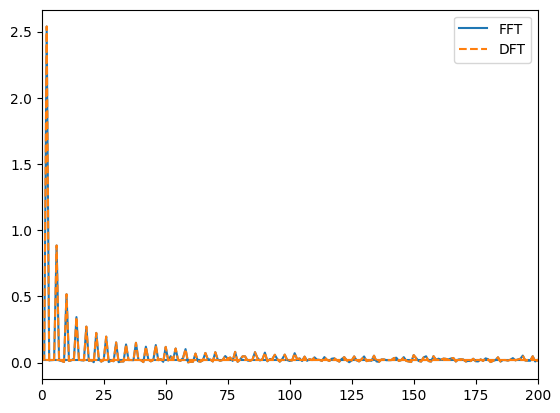

In [90]:
y_square_noise = add_noise(y_square)
y_dft_noise = DFT_slow(y_square_noise)
y_fft_noise = np.fft.fft(y_square_noise)

#сравнение устойчивости спектра функции на шум медленного и numpy преобразования фурье
plt.plot(freq_cos, np.abs(y_fft_noise) / num_point * 2, label = "FFT")
plt.plot(freq_cos, np.abs(y_dft_noise) / num_point * 2, linestyle='dashed', label = "DFT")
plt.legend()
plt.xlim(0, 200)
plt.show()

In [91]:
#БДПФ 
def FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    N_min = min(N, 32)
    
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    while X.shape[0] < N:
        x1 = int(X.shape[1] / 2)
        x2 = int(X.shape[1] / 2)
        X_even = X[:, :x1]
        X_odd = X[:, x2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

In [92]:
#Объявление констант
f_cos = 50
w = 2*np.pi*f_cos
t0 = 0
t1 = 4*np.pi
num_point = np.power(2, 14)
t_cos = np.linspace(t0, t1, num_point)
y_cos = np.cos(w*t_cos)

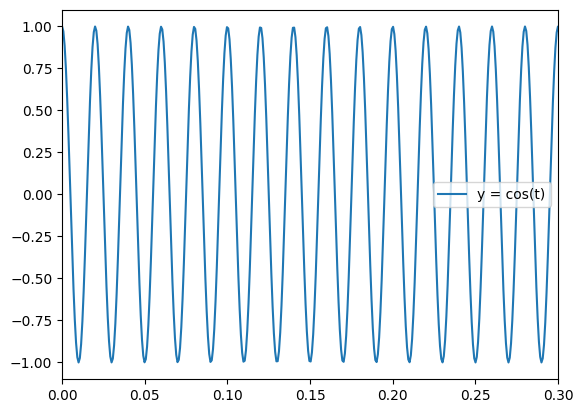

In [93]:
#График y = cos(t)
plt.plot(t_cos, y_cos, label = "y = cos(t)")
plt.legend()
plt.xlim(0, 0.3)
plt.show()

In [94]:
#Сравнение времени вычислений БДПФ и numpy fft
start_time = time.time()
y_cos_my_fft = FFT_vectorized(y_cos)
end_time = time.time()
t1 = end_time - start_time

start_time = time.time()
y_cos_fft = np.fft.fft(y_cos)
end_time = time.time()
t2 = end_time - start_time

print("my_FFT:", t1,
      "FFT:", t2)

my_FFT: 0.005111217498779297 FFT: 0.00045108795166015625


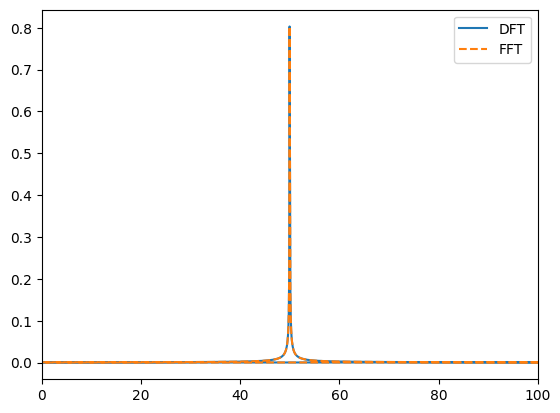

In [95]:
#Сравнение спектров
freq_cos = np.fft.fftfreq(len(t_cos), d=(t_cos[1]-t_cos[0]))
plt.plot(freq_cos, np.abs(y_cos_my_fft) / num_point * 2, label = "DFT")
plt.plot(freq_cos, np.abs(y_cos_fft) / num_point * 2, linestyle='dashed', label = "FFT")
plt.legend()
plt.xlim(0, 100)
plt.show()